# Este Notebook solo funciona en colab

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd

from google.colab import drive
from google.colab import files

import os
import shutil

from datetime import datetime

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
DRIVE_PATH = '/content/drive/MyDrive/Nodd3rApuntes/TFM/Files/AumentedData'
BASE_PATH = 'dataset'

In [ ]:
splits = os.listdir(DRIVE_PATH)
letters = sorted(os.listdir(os.path.join(DRIVE_PATH,splits[0])))
for letter in letters:
  print(f'--------- {letter} --------')
  for split in splits:
    amount = len(os.listdir(os.path.join(DRIVE_PATH, split,letter)))
    print(f'{letter} has {amount} images for {split}.')

--------- A --------
A has 248 images for test.
A has 1852 images for train.
A has 370 images for validation.
--------- B --------
B has 248 images for test.
B has 1852 images for train.
B has 370 images for validation.
--------- C --------
C has 248 images for test.
C has 1852 images for train.
C has 370 images for validation.
--------- D --------
D has 248 images for test.
D has 1852 images for train.
D has 370 images for validation.
--------- E --------
E has 248 images for test.
E has 1852 images for train.
E has 370 images for validation.
--------- F --------
F has 248 images for test.
F has 1852 images for train.
F has 370 images for validation.
--------- G --------
G has 248 images for test.
G has 1852 images for train.
G has 370 images for validation.
--------- H --------
H has 248 images for test.
H has 1852 images for train.
H has 370 images for validation.
--------- I --------
I has 248 images for test.
I has 1852 images for train.
I has 370 images for validation.
--------- 

In [ ]:
t0 = datetime.now()

if not os.path.exists(BASE_PATH):
  # os.mkdir(BASE_PATH)
  shutil.copytree(DRIVE_PATH,BASE_PATH)
  print('Data copied in',datetime.now()-t0)
else:
  print('El dataset ya existia')

Data copied in 0:25:34.131107


In [ ]:
categories = os.listdir(BASE_PATH)
letters = sorted(os.listdir(os.path.join(BASE_PATH,categories[0])))
df = np.zeros((len(categories)*len(letters),3))
df = pd.DataFrame(df, columns=['Category','Letter','Count'])
# print(df[(0+1)*2])
row = 0
for i, category in enumerate(categories):
  for letter in letters:
    df.iloc[row,0] = category
    df.iloc[row,1] = letter
    df.iloc[row,2] = len(os.listdir(os.path.join(BASE_PATH,category, letter)))
    row+=1

<ipython-input-11-f6592560f1a9>:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.iloc[row,0] = category
<ipython-input-11-f6592560f1a9>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.iloc[row,1] = letter


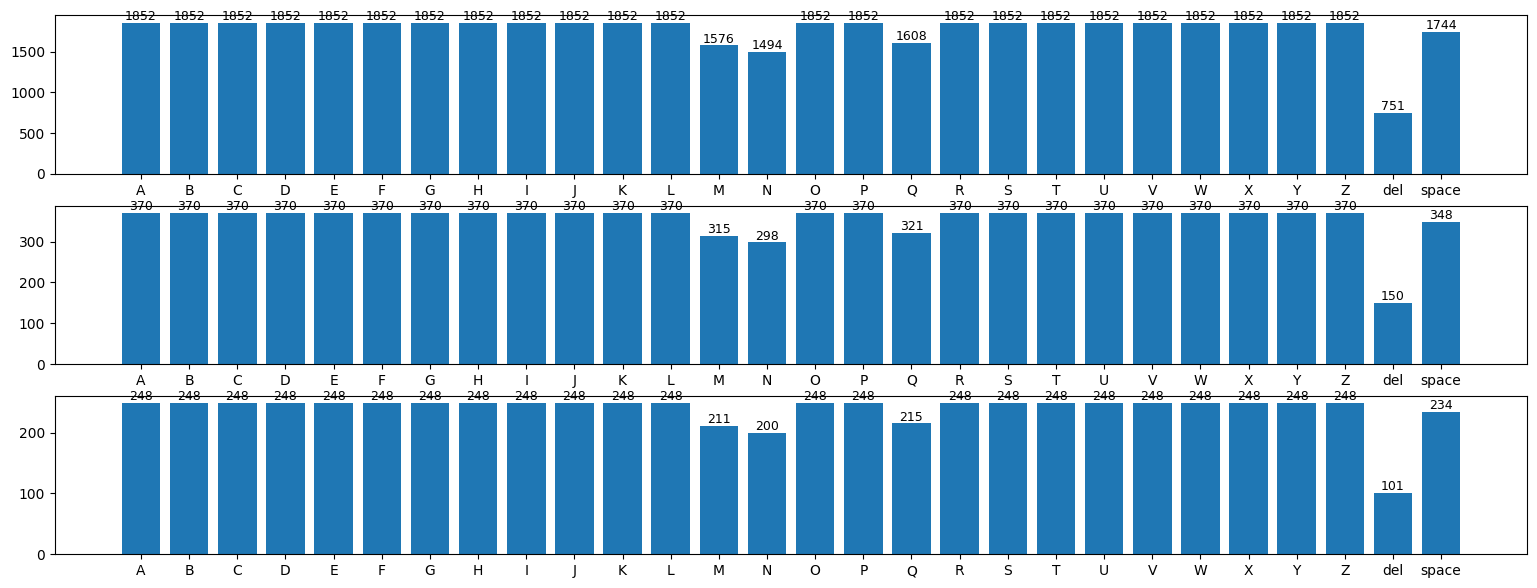

In [ ]:
plt.figure(figsize=(19,7))
# plt.subplots(3)
for i,category in enumerate(['train','validation','test']):
  plt.subplot(3,1,i+1)
  bars = plt.bar(letters, df[df['Category']==category]['Count'])
  for bar in bars:
      height = int(bar.get_height())
      plt.text(bar.get_x() + bar.get_width()/2, height, str(height),
             ha='center', va='bottom', fontsize=9)
plt.show()

In [ ]:
train_dir = os.path.join(BASE_PATH, 'train')
validation_dir = os.path.join(BASE_PATH, 'validation')
test_dir = os.path.join(BASE_PATH, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size =64,
    target_size=(300,300),
    class_mode= 'categorical',
    color_mode = 'rgb',
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size=64,
    target_size=(300,300),
    class_mode = 'categorical',
    color_mode = 'rgb',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=64,
    target_size=(300,300),
    class_mode='categorical',  # Asegúrate de que es el mismo class_mode que en train/val
    color_mode='rgb',
    shuffle=False,  # No mezclar para mantener el orden de los archivos
)

Found 49769 images belonging to 28 classes.
Found 9942 images belonging to 28 classes.
Found 6665 images belonging to 28 classes.


In [ ]:
def evaluate_model(name, model, history):
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=((10,5)))
  plt.plot(range(len(train_acc)),train_acc, 'o')
  plt.plot(range(len(train_acc)),val_acc, '-')
  plt.title('Train - Validation Accuracy')
  plt.legend(['Train','Validation'])
  plt.xticks(range(len(train_acc)))
  plt.grid(axis='x')

  plt.figure(figsize=((10,5)))
  plt.plot(range(len(train_acc)),train_loss, 'o')
  plt.plot(range(len(train_acc)),val_loss, '-')
  plt.title('Train - Validation Loss')
  plt.xticks(range(len(train_acc)))
  plt.legend(['Train','Validation'])
  plt.grid(axis='x')
  plt.show()


  y_pred = model.predict(test_generator)

  predicted_classes = np.argmax(y_pred,axis=1)
  class_labels = test_generator.class_indices.keys()

  cm = confusion_matrix(test_generator.classes, predicted_classes)

  plt.figure(figsize=(10,10))
  sns.heatmap(cm,annot=True, fmt='d',cmap='Blues',xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('Real')
  plt.title(f'Confusion matrix {name}')
  plt.show()

  test_loss, test_acc = model.evaluate(test_generator)
  print(f"Test Accuracy: {test_acc:.4f}"  )
  print(f"Max val Accuracy: {max(val_acc):.4f}"  )
  print(f"Max train Accuracy: {max(train_acc):.4f}"  )

In [ ]:
def save_model(name, model):
  name = 'ASP_2_'+name+'.keras'
  model.save(name)
  files.download(name)

## Training

In [ ]:
t0 = datetime.now()
model_7 = Sequential()

model_7.add(layers.Input(shape=(300,300,3)))

model_7.add(layers.Conv2D(8, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
# model_7.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Dropout(0.3))

model_7.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
# model_7.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.BatchNormalization())
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Dropout(0.3))

model_7.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu',padding='same'))
# model_7.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu',padding='same'))
# model_7.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu',padding='same'))
model_7.add(layers.MaxPool2D(pool_size=(2,2)))

model_7.add(layers.Flatten())
model_7.add(layers.Dense(512,activation='relu'))
model_7.add(layers.Dense(28,'softmax'))

model_7.summary()

model_7.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_path = '/content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_7_best.h5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,  # True si solo quieres guardar pesos
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience = 20,
    restore_best_weights = True)
history_7 = model_7.fit(
    train_generator,
    # steps_per_epoch = 250,
    epochs = 100,
    validation_data = validation_generator,
    callbacks =[early_stop,checkpoint],
    validation_steps = 100
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 300, 300, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300, 300, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 150, 150, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 150, 150, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 150, 150, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,887,164 (11.01 MB)

 Trainable params: 2,886,668 (11.01 MB)

 Non-trainable params: 496 (1.94 KB)

Epoch 1/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5342 - loss: 2.2613

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.87906, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_7_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 162s 198ms/step - accuracy: 0.5345 - loss: 2.2596 - val_accuracy: 0.8791 - val_loss: 0.3871
Epoch 2/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9353 - loss: 0.2240
Epoch 2: val_accuracy improved from 0.87906 to 0.89609, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_7_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 147s 188ms/step - accuracy: 0.9353 - loss: 0.2240 - val_accuracy: 0.8961 - val_loss: 0.3676
Epoch 3/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9609 - loss: 0.1371
Epoch 3: val_accuracy improved from 0.89609 to 0.95938, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_7_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 149s 192ms/step - accuracy: 0.9609 - loss: 0.1371 - val_accuracy: 0.9594 - val_loss: 0.1602
Epoch 4/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9716 - loss: 0.1081
Epoch 4: val_accuracy did not improve from 0.95938
778/778 ━━━━━━━━━━━━━━━━━━━━ 149s 192ms/step - accuracy: 0.9716 - loss: 0.1081 - val_accuracy: 0.9464 - val_loss: 0.1966
Epoch 5/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9787 - loss: 0.0816
Epoch 5: val_accuracy improved from 0.95938 to 0.96859, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_7_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 149s 191ms/step - accuracy: 0.9787 - loss: 0.0816 - val_accuracy: 0.9686 - val_loss: 0.1199
Epoch 6/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9808 - loss: 0.0720
Epoch 6: val_accuracy improved from 0.96859 to 0.97484, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_7_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 148s 190ms/step - accuracy: 0.9808 - loss: 0.0720 - val_accuracy: 0.9748 - val_loss: 0.1053
Epoch 7/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9842 - loss: 0.0648
Epoch 7: val_accuracy did not improve from 0.97484
778/778 ━━━━━━━━━━━━━━━━━━━━ 147s 189ms/step - accuracy: 0.9842 - loss: 0.0648 - val_accuracy: 0.9600 - val_loss: 0.1919
Epoch 8/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9864 - loss: 0.0562
Epoch 8: val_accuracy did not improve from 0.97484
778/778 ━━━━━━━━━━━━━━━━━━━━ 148s 190ms/step - accuracy: 0.9864 - loss: 0.0562 - val_accuracy: 0.4497 - val_loss: 4.3965
Epoch 9/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9861 - loss: 0.0573
Epoch 9: val_accuracy did not improve from 0.97484
778/778 ━━━━━━━━━━━━━━━━━━━━ 149s 191ms/step - accuracy: 0.9861 - loss: 0.0573 - val_accuracy: 0.9656 - val_loss: 0.1720
Epoch 10/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9891 - loss: 0.0436
Epoch 

778/778 ━━━━━━━━━━━━━━━━━━━━ 148s 190ms/step - accuracy: 0.9931 - loss: 0.0292 - val_accuracy: 0.9795 - val_loss: 0.1363
Epoch 14/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9924 - loss: 0.0324
Epoch 14: val_accuracy improved from 0.97953 to 0.98375, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_7_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 148s 190ms/step - accuracy: 0.9924 - loss: 0.0324 - val_accuracy: 0.9837 - val_loss: 0.1112
Epoch 15/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9927 - loss: 0.0338
Epoch 15: val_accuracy did not improve from 0.98375
778/778 ━━━━━━━━━━━━━━━━━━━━ 147s 189ms/step - accuracy: 0.9927 - loss: 0.0338 - val_accuracy: 0.9833 - val_loss: 0.1081
Epoch 16/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9945 - loss: 0.0224
Epoch 16: val_accuracy improved from 0.98375 to 0.98672, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_7_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 147s 189ms/step - accuracy: 0.9945 - loss: 0.0224 - val_accuracy: 0.9867 - val_loss: 0.0828
Epoch 17/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9943 - loss: 0.0250
Epoch 17: val_accuracy did not improve from 0.98672
778/778 ━━━━━━━━━━━━━━━━━━━━ 146s 188ms/step - accuracy: 0.9943 - loss: 0.0250 - val_accuracy: 0.9375 - val_loss: 0.3618
Epoch 18/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9946 - loss: 0.0252
Epoch 18: val_accuracy did not improve from 0.98672
778/778 ━━━━━━━━━━━━━━━━━━━━ 146s 187ms/step - accuracy: 0.9946 - loss: 0.0252 - val_accuracy: 0.9834 - val_loss: 0.1027
Epoch 19/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9950 - loss: 0.0194
Epoch 19: val_accuracy did not improve from 0.98672
778/778 ━━━━━━━━━━━━━━━━━━━━ 146s 188ms/step - accuracy: 0.9950 - loss: 0.0194 - val_accuracy: 0.9752 - val_loss: 0.1367
Epoch 20/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9962 - loss: 0.0170


778/778 ━━━━━━━━━━━━━━━━━━━━ 147s 189ms/step - accuracy: 0.9962 - loss: 0.0170 - val_accuracy: 0.9905 - val_loss: 0.0808
Epoch 21/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9951 - loss: 0.0219
Epoch 21: val_accuracy did not improve from 0.99047
778/778 ━━━━━━━━━━━━━━━━━━━━ 145s 186ms/step - accuracy: 0.9951 - loss: 0.0219 - val_accuracy: 0.9861 - val_loss: 0.1154
Epoch 22/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9954 - loss: 0.0202
Epoch 22: val_accuracy did not improve from 0.99047
778/778 ━━━━━━━━━━━━━━━━━━━━ 145s 187ms/step - accuracy: 0.9954 - loss: 0.0202 - val_accuracy: 0.9717 - val_loss: 0.1610
Epoch 23/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9963 - loss: 0.0204
Epoch 23: val_accuracy did not improve from 0.99047
778/778 ━━━━━━━━━━━━━━━━━━━━ 147s 188ms/step - accuracy: 0.9963 - loss: 0.0204 - val_accuracy: 0.9867 - val_loss: 0.0963
Epoch 24/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9973 - loss: 0.0124


778/778 ━━━━━━━━━━━━━━━━━━━━ 146s 187ms/step - accuracy: 0.9974 - loss: 0.0095 - val_accuracy: 0.9912 - val_loss: 0.0876
Epoch 28/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9981 - loss: 0.0092
Epoch 28: val_accuracy did not improve from 0.99125
778/778 ━━━━━━━━━━━━━━━━━━━━ 147s 189ms/step - accuracy: 0.9981 - loss: 0.0092 - val_accuracy: 0.9892 - val_loss: 0.0771
Epoch 29/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9971 - loss: 0.0149
Epoch 29: val_accuracy did not improve from 0.99125
778/778 ━━━━━━━━━━━━━━━━━━━━ 146s 187ms/step - accuracy: 0.9971 - loss: 0.0149 - val_accuracy: 0.9906 - val_loss: 0.0916
Epoch 30/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9977 - loss: 0.0109
Epoch 30: val_accuracy did not improve from 0.99125
778/778 ━━━━━━━━━━━━━━━━━━━━ 147s 189ms/step - accuracy: 0.9977 - loss: 0.0109 - val_accuracy: 0.9828 - val_loss: 0.1124
Epoch 31/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9983 - loss: 0.0085


778/778 ━━━━━━━━━━━━━━━━━━━━ 148s 190ms/step - accuracy: 0.9983 - loss: 0.0085 - val_accuracy: 0.9927 - val_loss: 0.0705
Epoch 32/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9983 - loss: 0.0066
Epoch 32: val_accuracy did not improve from 0.99266
778/778 ━━━━━━━━━━━━━━━━━━━━ 147s 189ms/step - accuracy: 0.9983 - loss: 0.0066 - val_accuracy: 0.9881 - val_loss: 0.1108
Epoch 33/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9979 - loss: 0.0088
Epoch 33: val_accuracy did not improve from 0.99266
778/778 ━━━━━━━━━━━━━━━━━━━━ 146s 187ms/step - accuracy: 0.9979 - loss: 0.0088 - val_accuracy: 0.9878 - val_loss: 0.0938
Epoch 34/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9979 - loss: 0.0082
Epoch 34: val_accuracy did not improve from 0.99266
778/778 ━━━━━━━━━━━━━━━━━━━━ 147s 190ms/step - accuracy: 0.9979 - loss: 0.0082 - val_accuracy: 0.9884 - val_loss: 0.1077
Epoch 35/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9980 - loss: 0.0096


778/778 ━━━━━━━━━━━━━━━━━━━━ 147s 189ms/step - accuracy: 0.9989 - loss: 0.0048 - val_accuracy: 0.9934 - val_loss: 0.0721
Epoch 48/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9981 - loss: 0.0093
Epoch 48: val_accuracy did not improve from 0.99344
778/778 ━━━━━━━━━━━━━━━━━━━━ 147s 189ms/step - accuracy: 0.9981 - loss: 0.0093 - val_accuracy: 0.9892 - val_loss: 0.1091
Epoch 49/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9991 - loss: 0.0034
Epoch 49: val_accuracy did not improve from 0.99344
778/778 ━━━━━━━━━━━━━━━━━━━━ 146s 187ms/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.9894 - val_loss: 0.1051
Epoch 50/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9990 - loss: 0.0038
Epoch 50: val_accuracy did not improve from 0.99344
778/778 ━━━━━━━━━━━━━━━━━━━━ 145s 187ms/step - accuracy: 0.9990 - loss: 0.0038 - val_accuracy: 0.9908 - val_loss: 0.0952
Epoch 51/100
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9994 - loss: 0.0031


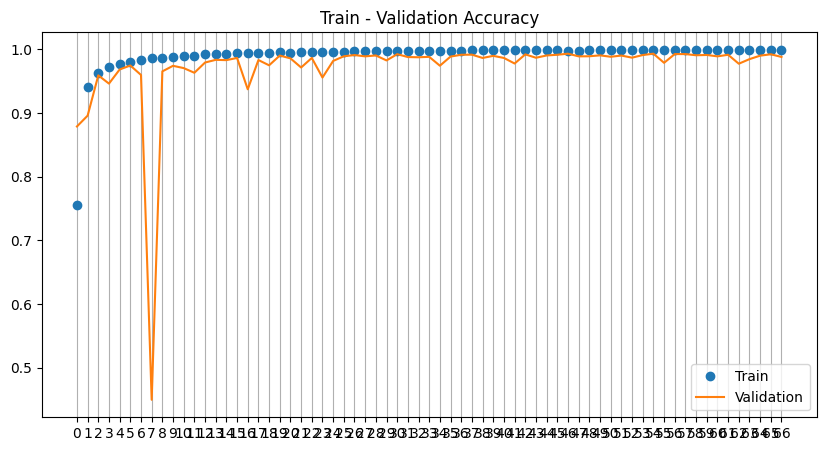

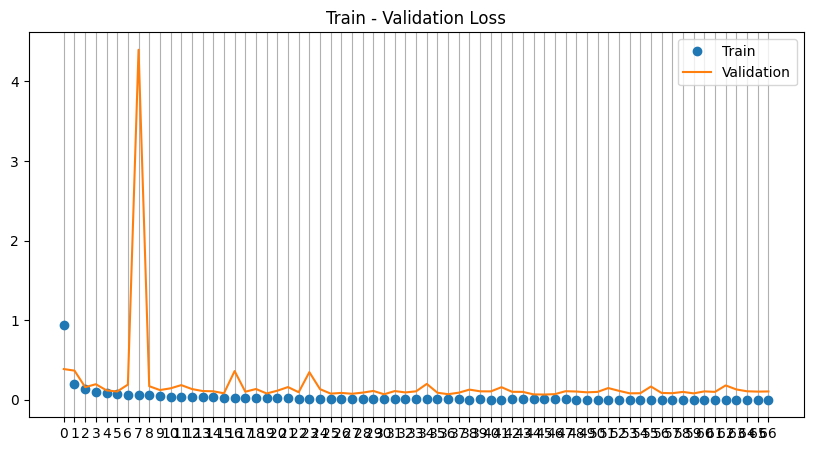

105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step


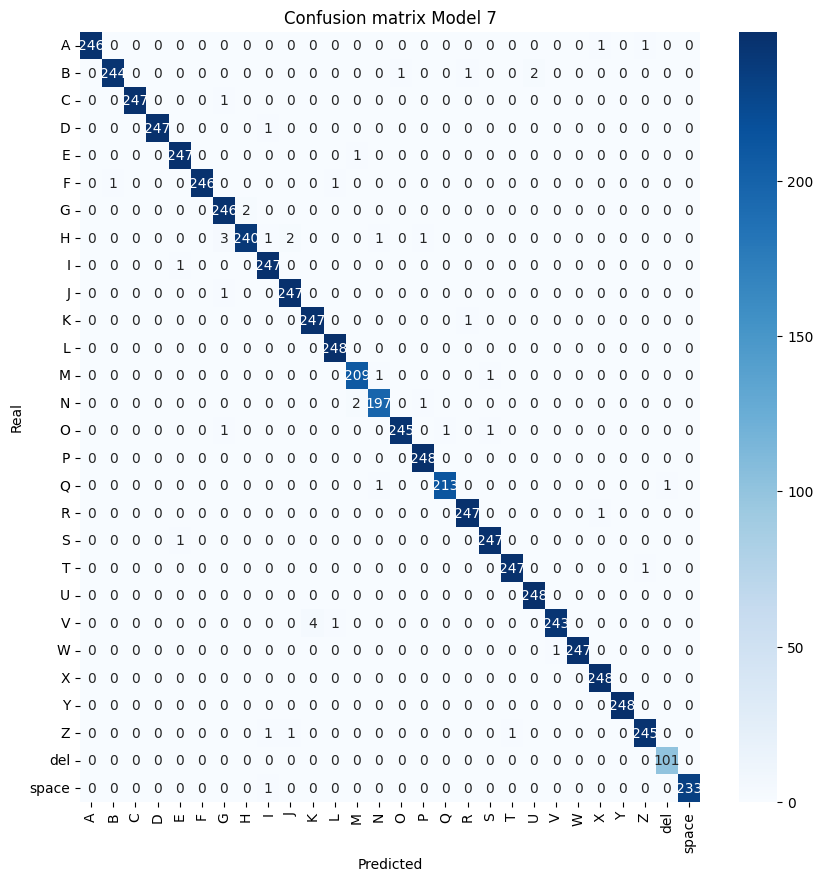

105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.9934 - loss: 0.0689
Test Accuracy: 0.9935
Max val Accuracy: 0.9934
Max train Accuracy: 0.9996


In [ ]:
evaluate_model('Model 7',model_7,history_7)

In [ ]:
save_model('model_7',model_7)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Intento 2

In [ ]:
t0 = datetime.now()
model_9 = Sequential()

model_9.add(layers.Input(shape=(300,300,3)))

model_9.add(layers.SeparableConv2D(16,(3,3), activation='relu', padding='same'))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPool2D(pool_size=(2,2)))

model_9.add(layers.SeparableConv2D(32,(3,3), activation='relu', padding='same'))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPool2D(pool_size=(2,2)))

model_9.add(layers.SeparableConv2D(64,(3,3), activation='relu', padding='same'))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPool2D(pool_size=(2,2)))
model_9.add(layers.Dropout(0.3))


model_9.add(layers.SeparableConv2D(128,(3,3), activation='relu', padding='same'))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPool2D(pool_size=(2,2)))
model_9.add(layers.Dropout(0.3))


model_9.add(layers.SeparableConv2D(256,(3,3), activation='relu', padding='same'))
model_9.add(layers.BatchNormalization())
model_9.add(layers.MaxPool2D(pool_size=(2,2)))


model_9.add(layers.Flatten())
model_9.add(layers.Dense(512,activation='relu'))
model_9.add(layers.Dropout(0.4))
model_9.add(layers.Dense(28,'softmax'))

model_9.summary()

model_9.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_9_path = '/content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_9_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # True si solo quieres guardar pesos
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 7,
    restore_best_weights = True)

history_9 = model_9.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 40,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks =[early_stop,checkpoint],
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_5              │ (None, 300, 300, 16)   │            91 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 300, 300, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 150, 150, 32)   │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_7              │ (None, 75, 75, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_8              │ (None, 37, 37, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_9              │ (None, 18, 18, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             

 Total params: 10,679,943 (40.74 MB)

 Trainable params: 10,678,951 (40.74 MB)

 Non-trainable params: 992 (3.88 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.3764 - loss: 5.2188
Epoch 1: val_loss improved from inf to 5.32707, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 191s 221ms/step - accuracy: 0.3766 - loss: 5.2147 - val_accuracy: 0.5534 - val_loss: 5.3271
Epoch 2/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8110 - loss: 0.6468
Epoch 2: val_loss did not improve from 5.32707
778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.8110 - loss: 0.6467 - val_accuracy: 0.7167 - val_loss: 5.4100
Epoch 3/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8878 - loss: 0.4179
Epoch 3: val_loss improved from 5.32707 to 3.05685, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.8878 - loss: 0.4179 - val_accuracy: 0.8214 - val_loss: 3.0569
Epoch 4/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9177 - loss: 0.3201
Epoch 4: val_loss improved from 3.05685 to 2.94510, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 155s 199ms/step - accuracy: 0.9177 - loss: 0.3201 - val_accuracy: 0.8464 - val_loss: 2.9451
Epoch 5/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9300 - loss: 0.2840
Epoch 5: val_loss improved from 2.94510 to 2.09490, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 201ms/step - accuracy: 0.9300 - loss: 0.2840 - val_accuracy: 0.9111 - val_loss: 2.0949
Epoch 6/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9406 - loss: 0.2543
Epoch 6: val_loss improved from 2.09490 to 2.05515, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 201ms/step - accuracy: 0.9406 - loss: 0.2543 - val_accuracy: 0.9065 - val_loss: 2.0552
Epoch 7/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9461 - loss: 0.2343
Epoch 7: val_loss did not improve from 2.05515
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9461 - loss: 0.2343 - val_accuracy: 0.8817 - val_loss: 3.0195
Epoch 8/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9520 - loss: 0.2292
Epoch 8: val_loss improved from 2.05515 to 1.95351, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9520 - loss: 0.2292 - val_accuracy: 0.9312 - val_loss: 1.9535
Epoch 9/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9525 - loss: 0.2134
Epoch 9: val_loss improved from 1.95351 to 1.31021, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9525 - loss: 0.2134 - val_accuracy: 0.9475 - val_loss: 1.3102
Epoch 10/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9570 - loss: 0.1996
Epoch 10: val_loss improved from 1.31021 to 0.36514, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9570 - loss: 0.1996 - val_accuracy: 0.9674 - val_loss: 0.3651
Epoch 11/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9614 - loss: 0.1831
Epoch 11: val_loss did not improve from 0.36514
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 201ms/step - accuracy: 0.9614 - loss: 0.1831 - val_accuracy: 0.9447 - val_loss: 1.0717
Epoch 12/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9629 - loss: 0.1754
Epoch 12: val_loss did not improve from 0.36514
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9629 - loss: 0.1754 - val_accuracy: 0.9628 - val_loss: 0.9353
Epoch 13/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9656 - loss: 0.1760
Epoch 13: val_loss did not improve from 0.36514
778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.9656 - loss: 0.1760 - val_accuracy: 0.9681 - val_loss: 0.7017
Epoch 14/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9657 - loss: 0.1666
Epoch 14: val_lo

778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 201ms/step - accuracy: 0.9697 - loss: 0.1569 - val_accuracy: 0.9482 - val_loss: 0.3241
Epoch 17/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9701 - loss: 0.1624
Epoch 17: val_loss improved from 0.32411 to 0.20549, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 202ms/step - accuracy: 0.9701 - loss: 0.1624 - val_accuracy: 0.9817 - val_loss: 0.2055
Epoch 18/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9696 - loss: 0.1617
Epoch 18: val_loss improved from 0.20549 to 0.20211, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 203ms/step - accuracy: 0.9696 - loss: 0.1617 - val_accuracy: 0.9761 - val_loss: 0.2021
Epoch 19/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9734 - loss: 0.1333
Epoch 19: val_loss did not improve from 0.20211
778/778 ━━━━━━━━━━━━━━━━━━━━ 155s 200ms/step - accuracy: 0.9734 - loss: 0.1333 - val_accuracy: 0.9807 - val_loss: 0.2416
Epoch 20/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9729 - loss: 0.1387
Epoch 20: val_loss did not improve from 0.20211
778/778 ━━━━━━━━━━━━━━━━━━━━ 155s 199ms/step - accuracy: 0.9729 - loss: 0.1387 - val_accuracy: 0.9795 - val_loss: 0.3560
Epoch 21/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9748 - loss: 0.1280
Epoch 21: val_loss improved from 0.20211 to 0.19765, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 202ms/step - accuracy: 0.9748 - loss: 0.1280 - val_accuracy: 0.9772 - val_loss: 0.1977
Epoch 22/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9767 - loss: 0.1204
Epoch 22: val_loss did not improve from 0.19765
778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.9767 - loss: 0.1204 - val_accuracy: 0.9708 - val_loss: 0.4756
Epoch 23/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9771 - loss: 0.1186
Epoch 23: val_loss did not improve from 0.19765
778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.9771 - loss: 0.1186 - val_accuracy: 0.9632 - val_loss: 0.3202
Epoch 24/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9792 - loss: 0.1136
Epoch 24: val_loss did not improve from 0.19765
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9792 - loss: 0.1136 - val_accuracy: 0.9826 - val_loss: 0.2460
Epoch 25/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9797 - loss: 0.1070
Epoch 25: val_lo

778/778 ━━━━━━━━━━━━━━━━━━━━ 159s 205ms/step - accuracy: 0.9797 - loss: 0.1070 - val_accuracy: 0.9849 - val_loss: 0.1651
Epoch 26/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9797 - loss: 0.1085
Epoch 26: val_loss did not improve from 0.16509
778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.9797 - loss: 0.1084 - val_accuracy: 0.9865 - val_loss: 0.1873
Epoch 27/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9818 - loss: 0.0999
Epoch 27: val_loss improved from 0.16509 to 0.12019, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 201ms/step - accuracy: 0.9818 - loss: 0.0999 - val_accuracy: 0.9841 - val_loss: 0.1202
Epoch 28/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9806 - loss: 0.0979
Epoch 28: val_loss did not improve from 0.12019
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9806 - loss: 0.0979 - val_accuracy: 0.9868 - val_loss: 0.1429
Epoch 29/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9809 - loss: 0.1096
Epoch 29: val_loss did not improve from 0.12019
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9809 - loss: 0.1096 - val_accuracy: 0.9833 - val_loss: 0.2297
Epoch 30/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9821 - loss: 0.0883
Epoch 30: val_loss did not improve from 0.12019
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9821 - loss: 0.0883 - val_accuracy: 0.9733 - val_loss: 0.2242
Epoch 31/40
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9848 - loss: 0.0811
Epoch 31: val_lo

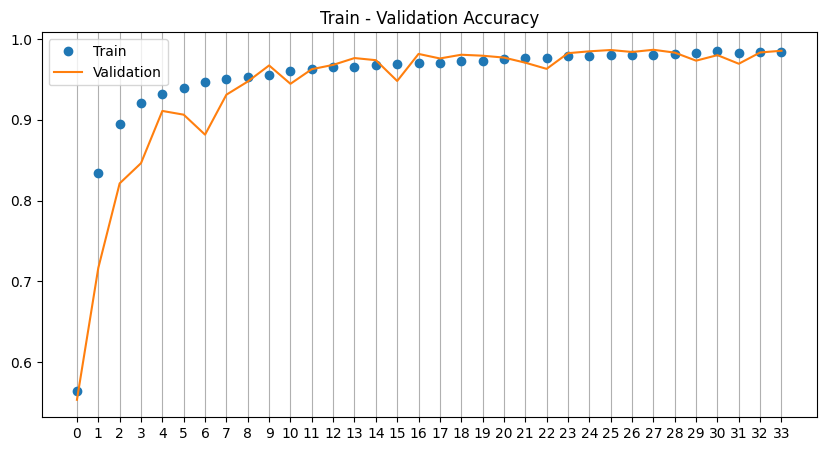

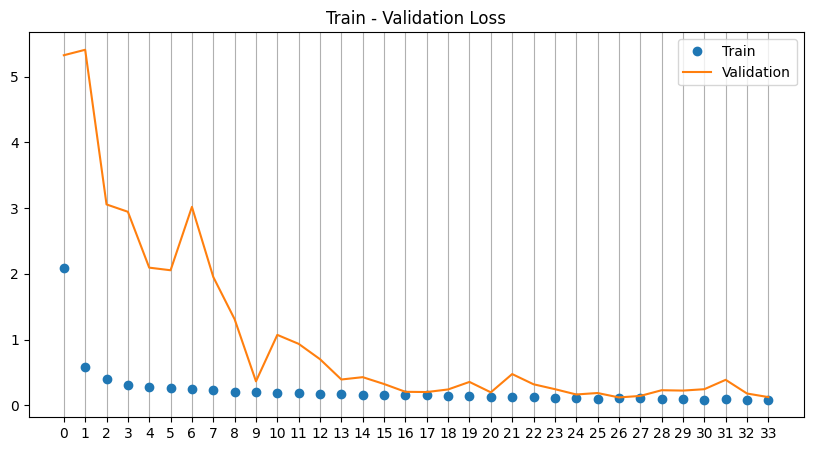

105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step


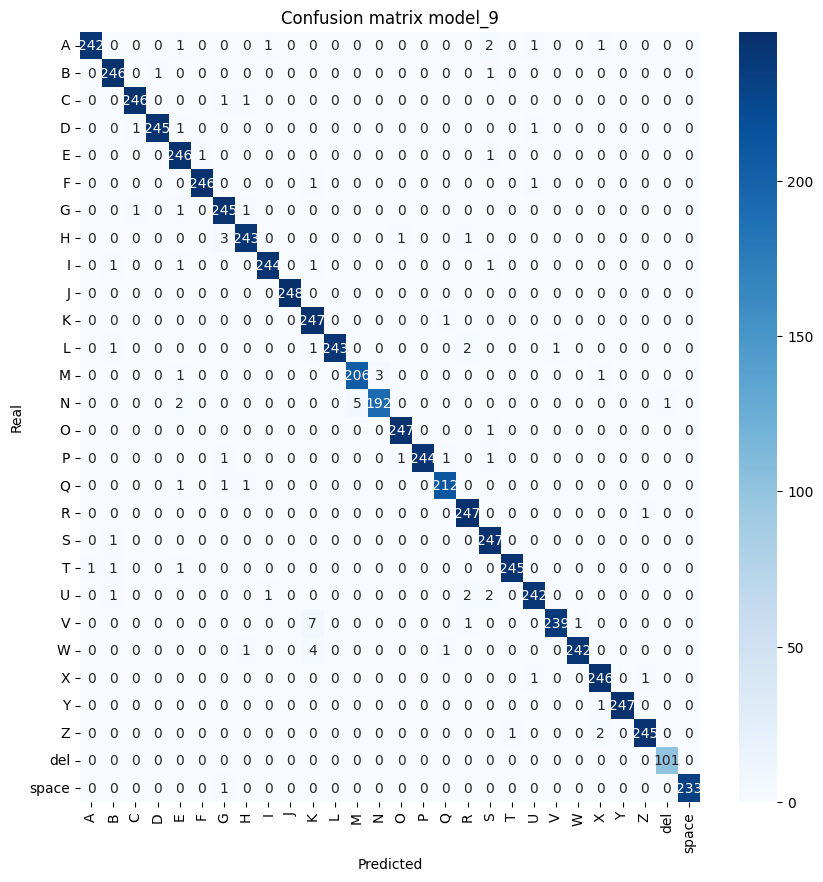

105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.9841 - loss: 0.0987
Test Accuracy: 0.9839
Max val Accuracy: 0.9868
Max train Accuracy: 0.9847


In [ ]:
evaluate_model('model_9',model_9,history_9)

In [ ]:
save_model('model_9',model_9)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##intento 3

In [ ]:
t0 = datetime.now()
model_10 = Sequential()

model_10.add(layers.Input(shape=(300,300,3)))

model_10.add(layers.SeparableConv2D(16,(3,3), activation='relu', padding='same'))
model_10.add(layers.BatchNormalization())
model_10.add(layers.MaxPool2D(pool_size=(2,2)))

model_10.add(layers.SeparableConv2D(32,(3,3), activation='relu', padding='same'))
model_10.add(layers.BatchNormalization())
model_10.add(layers.MaxPool2D(pool_size=(2,2)))
model_10.add(layers.Dropout(0.3))

model_10.add(layers.SeparableConv2D(64,(3,3), activation='relu', padding='same'))
model_10.add(layers.BatchNormalization())
model_10.add(layers.MaxPool2D(pool_size=(2,2)))


model_10.add(layers.SeparableConv2D(128,(3,3), activation='relu', padding='same'))
model_10.add(layers.BatchNormalization())
model_10.add(layers.MaxPool2D(pool_size=(2,2)))
model_10.add(layers.Dropout(0.4))


model_10.add(layers.SeparableConv2D(256,(3,3), activation='relu', padding='same'))
model_10.add(layers.BatchNormalization())
model_10.add(layers.MaxPool2D(pool_size=(2,2)))
model_10.add(layers.Dropout(0.4))


model_10.add(layers.Flatten())
model_10.add(layers.Dense(512,activation='relu'))
model_10.add(layers.Dropout(0.4))
model_10.add(layers.Dense(28,'softmax'))

model_10.summary()

model_10.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_10_path = '/content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_10_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # True si solo quieres guardar pesos
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 4,
    restore_best_weights = True)

history_10 = model_10.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 25,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks =[early_stop,checkpoint],
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 300, 300, 16)   │            91 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300, 300, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 150, 150, 32)   │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 75, 75, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 37, 37, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 18, 18, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    10,617,34

 Total params: 10,679,943 (40.74 MB)

 Trainable params: 10,678,951 (40.74 MB)

 Non-trainable params: 992 (3.88 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.3646 - loss: 3.9314
Epoch 1: val_loss improved from inf to 0.91240, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 197s 229ms/step - accuracy: 0.3648 - loss: 3.9288 - val_accuracy: 0.7471 - val_loss: 0.9124
Epoch 2/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7313 - loss: 0.9319
Epoch 2: val_loss improved from 0.91240 to 0.77099, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 204ms/step - accuracy: 0.7314 - loss: 0.9318 - val_accuracy: 0.7722 - val_loss: 0.7710
Epoch 3/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8113 - loss: 0.6890
Epoch 3: val_loss did not improve from 0.77099
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 201ms/step - accuracy: 0.8113 - loss: 0.6890 - val_accuracy: 0.7174 - val_loss: 0.9364
Epoch 4/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8599 - loss: 0.5316
Epoch 4: val_loss improved from 0.77099 to 0.32593, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 203ms/step - accuracy: 0.8599 - loss: 0.5316 - val_accuracy: 0.9056 - val_loss: 0.3259
Epoch 5/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8854 - loss: 0.4427
Epoch 5: val_loss improved from 0.32593 to 0.28675, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 202ms/step - accuracy: 0.8854 - loss: 0.4427 - val_accuracy: 0.9141 - val_loss: 0.2868
Epoch 6/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9032 - loss: 0.3827
Epoch 6: val_loss improved from 0.28675 to 0.22717, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 204ms/step - accuracy: 0.9032 - loss: 0.3826 - val_accuracy: 0.9336 - val_loss: 0.2272
Epoch 7/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9137 - loss: 0.3441
Epoch 7: val_loss improved from 0.22717 to 0.19551, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 159s 204ms/step - accuracy: 0.9137 - loss: 0.3441 - val_accuracy: 0.9438 - val_loss: 0.1955
Epoch 8/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9269 - loss: 0.2928
Epoch 8: val_loss did not improve from 0.19551
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9269 - loss: 0.2928 - val_accuracy: 0.9022 - val_loss: 0.3340
Epoch 9/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9324 - loss: 0.2729
Epoch 9: val_loss improved from 0.19551 to 0.16279, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 203ms/step - accuracy: 0.9324 - loss: 0.2729 - val_accuracy: 0.9566 - val_loss: 0.1628
Epoch 10/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9360 - loss: 0.2569
Epoch 10: val_loss did not improve from 0.16279
778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 202ms/step - accuracy: 0.9360 - loss: 0.2569 - val_accuracy: 0.9191 - val_loss: 0.2847
Epoch 11/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9446 - loss: 0.2213
Epoch 11: val_loss improved from 0.16279 to 0.15425, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 159s 205ms/step - accuracy: 0.9446 - loss: 0.2213 - val_accuracy: 0.9562 - val_loss: 0.1542
Epoch 12/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9469 - loss: 0.2205
Epoch 12: val_loss improved from 0.15425 to 0.11468, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_9_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 201ms/step - accuracy: 0.9469 - loss: 0.2205 - val_accuracy: 0.9670 - val_loss: 0.1147
Epoch 13/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9512 - loss: 0.2040
Epoch 13: val_loss did not improve from 0.11468
778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 204ms/step - accuracy: 0.9512 - loss: 0.2040 - val_accuracy: 0.9524 - val_loss: 0.1633
Epoch 14/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9535 - loss: 0.1941
Epoch 14: val_loss did not improve from 0.11468
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9535 - loss: 0.1941 - val_accuracy: 0.9621 - val_loss: 0.1354
Epoch 15/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9586 - loss: 0.1709
Epoch 15: val_loss did not improve from 0.11468
778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 203ms/step - accuracy: 0.9586 - loss: 0.1709 - val_accuracy: 0.9612 - val_loss: 0.1380
Epoch 16/25
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9610 - loss: 0.1570
Epoch 16: val_lo

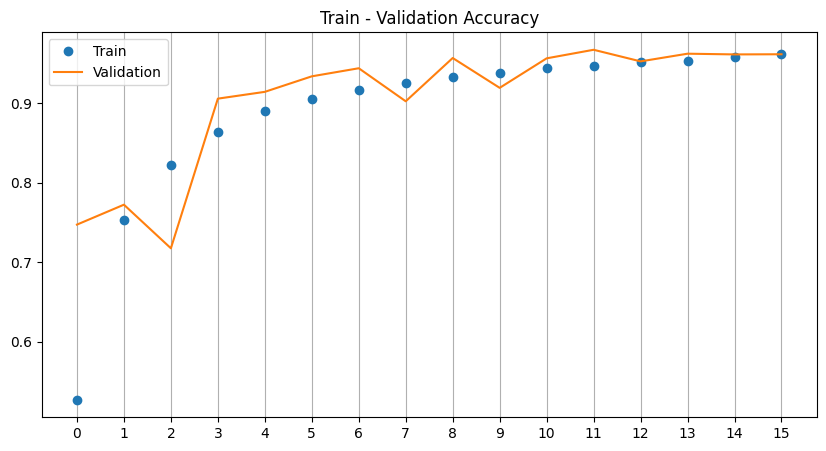

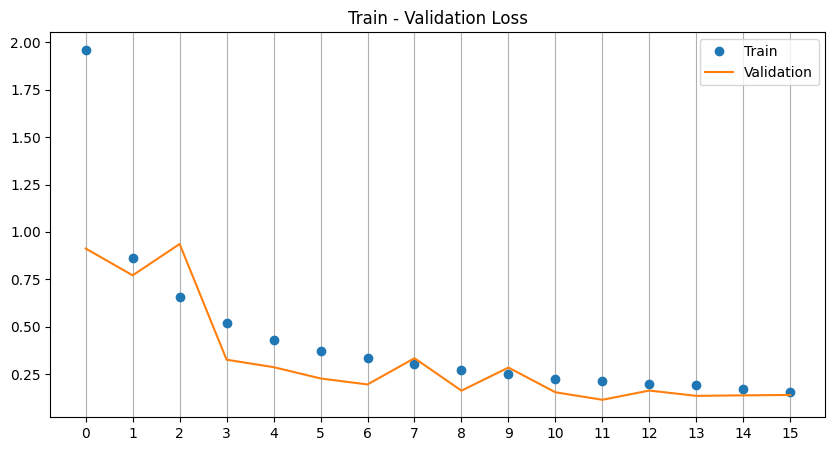

105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step


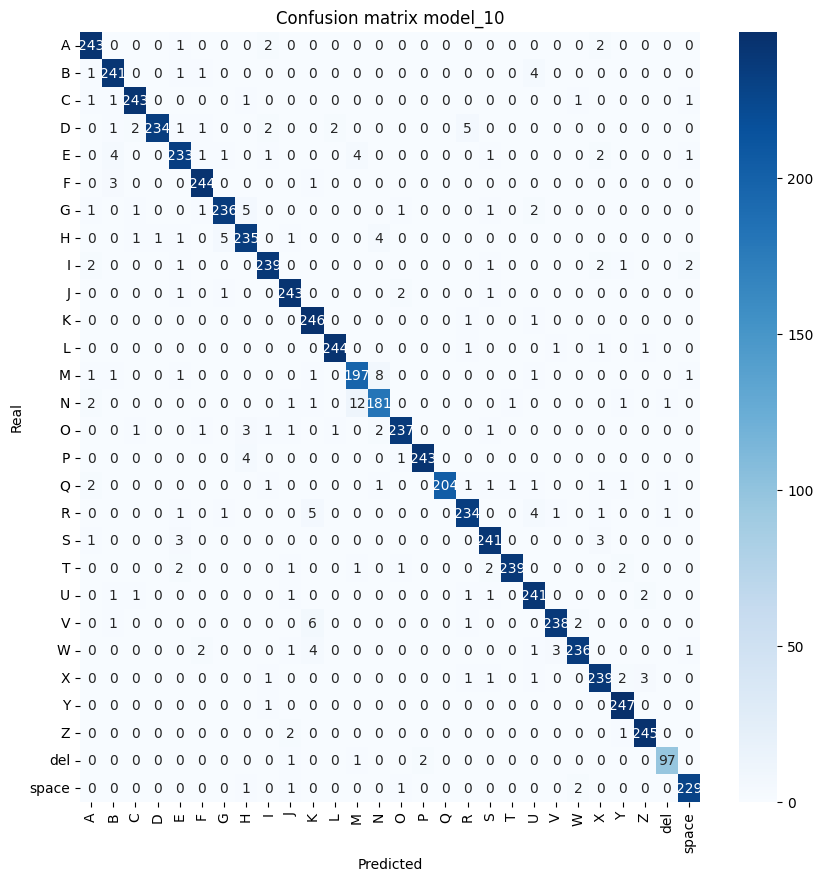

105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.9664 - loss: 0.1140
Test Accuracy: 0.9659
Max val Accuracy: 0.9670
Max train Accuracy: 0.9617


In [ ]:
evaluate_model('model_10',model_10, history_10)

In [ ]:
save_model('model_10',model_10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
t0 = datetime.now()
model_11 = Sequential()

model_11.add(layers.Input(shape=(300,300,3)))

model_11.add(layers.Conv2D(8, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.BatchNormalization())
model_11.add(layers.MaxPool2D(pool_size=(2,2)))
model_11.add(layers.Dropout(0.4))

model_11.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(16, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.BatchNormalization())
model_11.add(layers.MaxPool2D(pool_size=(2,2)))
model_11.add(layers.Dropout(0.3))

model_11.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(32, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.BatchNormalization())
model_11.add(layers.MaxPool2D(pool_size=(2,2)))
model_11.add(layers.Dropout(0.4))

model_11.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.BatchNormalization())
model_11.add(layers.MaxPool2D(pool_size=(2,2)))

model_11.add(layers.Dropout(0.4))

model_11.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.BatchNormalization())
model_11.add(layers.MaxPool2D(pool_size=(2,2)))

model_11.add(layers.Dropout(0.5))

model_11.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.Conv2D(256, kernel_size=(3,3),activation='relu',padding='same'))
model_11.add(layers.MaxPool2D(pool_size=(2,2)))
model_11.add(layers.Dropout(0.5))

model_11.add(layers.Flatten())
model_11.add(layers.Dense(512,activation='relu'))
model_11.add(layers.Dense(28,'softmax'))

model_11.summary()

model_11.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_path = '/content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_11_best.h5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # True si solo quieres guardar pesos
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 5,
    restore_best_weights = True)
history_11 = model_11.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 30,
    validation_data = validation_generator,
    callbacks =[early_stop,checkpoint],
    validation_steps = len(validation_generator)
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 300, 300, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 150, 150, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 150, 150, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 150, 150, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 150, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 18, 18, 128)    │       147,58

 Total params: 3,477,244 (13.26 MB)

 Trainable params: 3,476,748 (13.26 MB)

 Non-trainable params: 496 (1.94 KB)

Epoch 1/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.3770 - loss: 2.3143
Epoch 1: val_loss improved from inf to 0.44676, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 194s 226ms/step - accuracy: 0.3773 - loss: 2.3131 - val_accuracy: 0.8640 - val_loss: 0.4468
Epoch 2/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8479 - loss: 0.5186
Epoch 2: val_loss did not improve from 0.44676
778/778 ━━━━━━━━━━━━━━━━━━━━ 159s 204ms/step - accuracy: 0.8479 - loss: 0.5186 - val_accuracy: 0.8529 - val_loss: 0.4850
Epoch 3/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8983 - loss: 0.3418
Epoch 3: val_loss improved from 0.44676 to 0.25367, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 160s 205ms/step - accuracy: 0.8983 - loss: 0.3418 - val_accuracy: 0.9295 - val_loss: 0.2537
Epoch 4/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9168 - loss: 0.2840
Epoch 4: val_loss improved from 0.25367 to 0.24296, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 202ms/step - accuracy: 0.9168 - loss: 0.2840 - val_accuracy: 0.9303 - val_loss: 0.2430
Epoch 5/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9312 - loss: 0.2452
Epoch 5: val_loss did not improve from 0.24296
778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 202ms/step - accuracy: 0.9312 - loss: 0.2452 - val_accuracy: 0.9273 - val_loss: 0.2886
Epoch 6/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9409 - loss: 0.2131
Epoch 6: val_loss improved from 0.24296 to 0.20454, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 159s 205ms/step - accuracy: 0.9409 - loss: 0.2131 - val_accuracy: 0.9408 - val_loss: 0.2045
Epoch 7/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9451 - loss: 0.1984
Epoch 7: val_loss did not improve from 0.20454
778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 203ms/step - accuracy: 0.9451 - loss: 0.1984 - val_accuracy: 0.9359 - val_loss: 0.2404
Epoch 8/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9527 - loss: 0.1802
Epoch 8: val_loss did not improve from 0.20454
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 201ms/step - accuracy: 0.9527 - loss: 0.1802 - val_accuracy: 0.9425 - val_loss: 0.2233
Epoch 9/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9565 - loss: 0.1620
Epoch 9: val_loss improved from 0.20454 to 0.14312, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 202ms/step - accuracy: 0.9565 - loss: 0.1620 - val_accuracy: 0.9689 - val_loss: 0.1431
Epoch 10/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9593 - loss: 0.1562
Epoch 10: val_loss did not improve from 0.14312
778/778 ━━━━━━━━━━━━━━━━━━━━ 155s 199ms/step - accuracy: 0.9593 - loss: 0.1562 - val_accuracy: 0.9575 - val_loss: 0.1693
Epoch 11/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9629 - loss: 0.1446
Epoch 11: val_loss improved from 0.14312 to 0.07921, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 201ms/step - accuracy: 0.9629 - loss: 0.1446 - val_accuracy: 0.9799 - val_loss: 0.0792
Epoch 12/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9668 - loss: 0.1271
Epoch 12: val_loss did not improve from 0.07921
778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.9668 - loss: 0.1271 - val_accuracy: 0.9712 - val_loss: 0.1149
Epoch 13/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9699 - loss: 0.1189
Epoch 13: val_loss did not improve from 0.07921
778/778 ━━━━━━━━━━━━━━━━━━━━ 155s 199ms/step - accuracy: 0.9699 - loss: 0.1189 - val_accuracy: 0.9630 - val_loss: 0.1624
Epoch 14/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9713 - loss: 0.1124
Epoch 14: val_loss improved from 0.07921 to 0.06338, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 201ms/step - accuracy: 0.9713 - loss: 0.1124 - val_accuracy: 0.9832 - val_loss: 0.0634
Epoch 15/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9742 - loss: 0.1004
Epoch 15: val_loss did not improve from 0.06338
778/778 ━━━━━━━━━━━━━━━━━━━━ 155s 200ms/step - accuracy: 0.9742 - loss: 0.1004 - val_accuracy: 0.9778 - val_loss: 0.0935
Epoch 16/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9760 - loss: 0.0927
Epoch 16: val_loss improved from 0.06338 to 0.05847, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_11_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 202ms/step - accuracy: 0.9760 - loss: 0.0927 - val_accuracy: 0.9853 - val_loss: 0.0585
Epoch 17/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9773 - loss: 0.0820
Epoch 17: val_loss did not improve from 0.05847
778/778 ━━━━━━━━━━━━━━━━━━━━ 158s 203ms/step - accuracy: 0.9773 - loss: 0.0820 - val_accuracy: 0.9713 - val_loss: 0.1027
Epoch 18/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9789 - loss: 0.0821
Epoch 18: val_loss did not improve from 0.05847
778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.9789 - loss: 0.0822 - val_accuracy: 0.9797 - val_loss: 0.0771
Epoch 19/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9781 - loss: 0.0816
Epoch 19: val_loss did not improve from 0.05847
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9781 - loss: 0.0815 - val_accuracy: 0.9657 - val_loss: 0.1362
Epoch 20/30
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9815 - loss: 0.0667
Epoch 20: val_lo

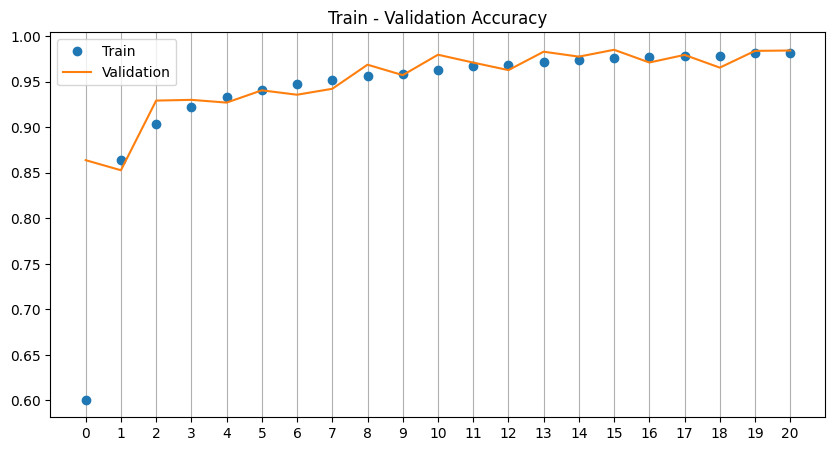

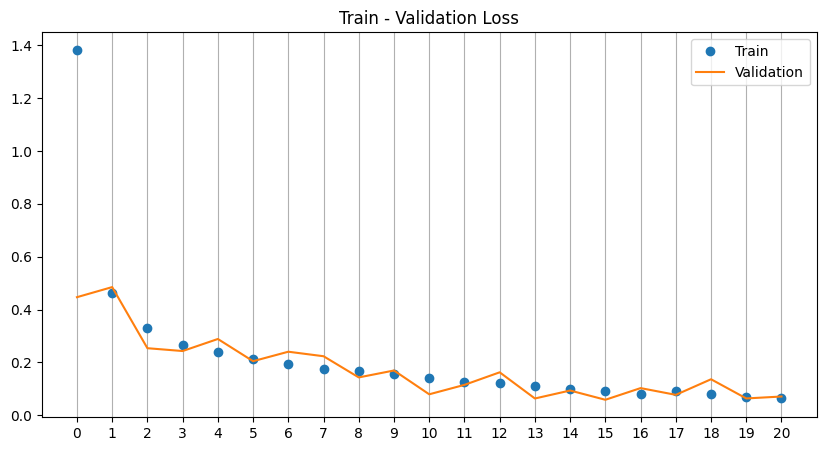

105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step


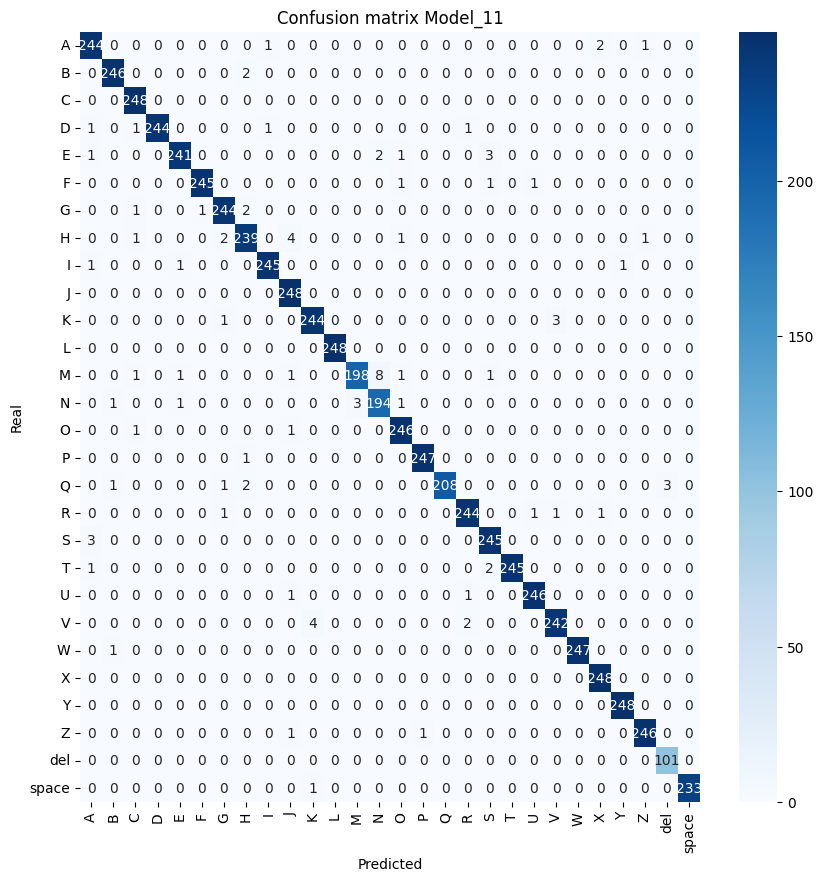

105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - accuracy: 0.9847 - loss: 0.0596
Test Accuracy: 0.9859
Max val Accuracy: 0.9853
Max train Accuracy: 0.9820


In [ ]:
evaluate_model('Model_11',model_11,history_11)

In [ ]:
save_model('model_11',model_11)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
t0 = datetime.now()
model_12 = Sequential()

model_12.add(layers.Input(shape=(300,300,3)))

model_12.add(layers.SeparableConv2D(16,(3,3), activation='relu', padding='same'))
model_12.add(layers.BatchNormalization())
model_12.add(layers.MaxPool2D(pool_size=(2,2)))
model_12.add(layers.Dropout(0.2))

model_12.add(layers.SeparableConv2D(16,(3,3), activation='relu', padding='same'))
model_12.add(layers.BatchNormalization())
model_12.add(layers.MaxPool2D(pool_size=(2,2)))
model_12.add(layers.Dropout(0.4))

model_12.add(layers.SeparableConv2D(32,(3,3), activation='relu', padding='same'))
model_12.add(layers.BatchNormalization())
model_12.add(layers.MaxPool2D(pool_size=(2,2)))
model_12.add(layers.Dropout(0.4))

model_12.add(layers.SeparableConv2D(64,(3,3), activation='relu', padding='same'))
model_12.add(layers.BatchNormalization())
model_12.add(layers.MaxPool2D(pool_size=(2,2)))
model_12.add(layers.Dropout(0.5))


model_12.add(layers.SeparableConv2D(128,(3,3), activation='relu', padding='same'))
model_12.add(layers.BatchNormalization())
model_12.add(layers.MaxPool2D(pool_size=(2,2)))
model_12.add(layers.Dropout(0.4))


model_12.add(layers.SeparableConv2D(256,(3,3), activation='relu', padding='same'))
model_12.add(layers.BatchNormalization())
model_12.add(layers.MaxPool2D(pool_size=(2,2)))
model_12.add(layers.Dropout(0.3))


model_12.add(layers.Flatten())
model_12.add(layers.Dense(512,activation='relu'))
model_12.add(layers.Dropout(0.4))
model_12.add(layers.Dense(28,'softmax'))

model_12.summary()

model_12.compile(optimizer= optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_12_path = '/content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_12_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # True si solo quieres guardar pesos
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience = 8,
    restore_best_weights = True)

history_12 = model_12.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks =[early_stop,checkpoint],
)
print(f'Taks done in {datetime.now()-t0}')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_20             │ (None, 300, 300, 16)   │            91 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 300, 300, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_21             │ (None, 150, 150, 16)   │           416 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 150, 150, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_22             │ (None, 75, 75, 32)     │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_23             │ (None, 37, 37, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_24             │ (None, 18, 18, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 9, 9, 128)      │             

 Total params: 2,160,743 (8.24 MB)

 Trainable params: 2,159,719 (8.24 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.2090 - loss: 3.4146
Epoch 1: val_loss improved from inf to 7.02204, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 178s 212ms/step - accuracy: 0.2092 - loss: 3.4132 - val_accuracy: 0.3006 - val_loss: 7.0220
Epoch 2/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6428 - loss: 1.1915
Epoch 2: val_loss did not improve from 7.02204
778/778 ━━━━━━━━━━━━━━━━━━━━ 153s 197ms/step - accuracy: 0.6428 - loss: 1.1914 - val_accuracy: 0.3989 - val_loss: 9.8448
Epoch 3/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7468 - loss: 0.8656
Epoch 3: val_loss improved from 7.02204 to 3.60948, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 153s 197ms/step - accuracy: 0.7469 - loss: 0.8655 - val_accuracy: 0.6199 - val_loss: 3.6095
Epoch 4/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7992 - loss: 0.6824
Epoch 4: val_loss improved from 3.60948 to 1.87005, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 153s 197ms/step - accuracy: 0.7992 - loss: 0.6824 - val_accuracy: 0.7185 - val_loss: 1.8701
Epoch 5/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8343 - loss: 0.5731
Epoch 5: val_loss improved from 1.87005 to 1.29374, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 153s 197ms/step - accuracy: 0.8343 - loss: 0.5731 - val_accuracy: 0.7690 - val_loss: 1.2937
Epoch 6/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8564 - loss: 0.4853
Epoch 6: val_loss improved from 1.29374 to 0.92294, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.8564 - loss: 0.4853 - val_accuracy: 0.8249 - val_loss: 0.9229
Epoch 7/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8734 - loss: 0.4303
Epoch 7: val_loss improved from 0.92294 to 0.91563, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 152s 196ms/step - accuracy: 0.8734 - loss: 0.4303 - val_accuracy: 0.8425 - val_loss: 0.9156
Epoch 8/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8904 - loss: 0.3797
Epoch 8: val_loss improved from 0.91563 to 0.66387, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 201ms/step - accuracy: 0.8904 - loss: 0.3797 - val_accuracy: 0.8605 - val_loss: 0.6639
Epoch 9/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8990 - loss: 0.3452
Epoch 9: val_loss did not improve from 0.66387
778/778 ━━━━━━━━━━━━━━━━━━━━ 153s 196ms/step - accuracy: 0.8990 - loss: 0.3452 - val_accuracy: 0.8398 - val_loss: 0.6841
Epoch 10/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9033 - loss: 0.3347
Epoch 10: val_loss improved from 0.66387 to 0.55618, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 155s 199ms/step - accuracy: 0.9033 - loss: 0.3347 - val_accuracy: 0.8565 - val_loss: 0.5562
Epoch 11/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9128 - loss: 0.2915
Epoch 11: val_loss improved from 0.55618 to 0.34529, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.9128 - loss: 0.2915 - val_accuracy: 0.9083 - val_loss: 0.3453
Epoch 12/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9203 - loss: 0.2716
Epoch 12: val_loss did not improve from 0.34529
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9203 - loss: 0.2716 - val_accuracy: 0.8969 - val_loss: 0.4239
Epoch 13/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9274 - loss: 0.2451
Epoch 13: val_loss did not improve from 0.34529
778/778 ━━━━━━━━━━━━━━━━━━━━ 153s 196ms/step - accuracy: 0.9274 - loss: 0.2451 - val_accuracy: 0.8988 - val_loss: 0.4200
Epoch 14/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9292 - loss: 0.2361
Epoch 14: val_loss improved from 0.34529 to 0.26112, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 152s 195ms/step - accuracy: 0.9292 - loss: 0.2361 - val_accuracy: 0.9293 - val_loss: 0.2611
Epoch 15/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9365 - loss: 0.2115
Epoch 15: val_loss improved from 0.26112 to 0.24777, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 157s 202ms/step - accuracy: 0.9365 - loss: 0.2115 - val_accuracy: 0.9322 - val_loss: 0.2478
Epoch 16/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9402 - loss: 0.2046
Epoch 16: val_loss did not improve from 0.24777
778/778 ━━━━━━━━━━━━━━━━━━━━ 153s 196ms/step - accuracy: 0.9402 - loss: 0.2046 - val_accuracy: 0.9082 - val_loss: 0.3419
Epoch 17/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9423 - loss: 0.1911
Epoch 17: val_loss did not improve from 0.24777
778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.9423 - loss: 0.1911 - val_accuracy: 0.9269 - val_loss: 0.2634
Epoch 18/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9476 - loss: 0.1762
Epoch 18: val_loss improved from 0.24777 to 0.23370, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 155s 199ms/step - accuracy: 0.9476 - loss: 0.1762 - val_accuracy: 0.9375 - val_loss: 0.2337
Epoch 19/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9495 - loss: 0.1664
Epoch 19: val_loss did not improve from 0.23370
778/778 ━━━━━━━━━━━━━━━━━━━━ 152s 196ms/step - accuracy: 0.9495 - loss: 0.1664 - val_accuracy: 0.9187 - val_loss: 0.3037
Epoch 20/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9527 - loss: 0.1592
Epoch 20: val_loss improved from 0.23370 to 0.18802, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9527 - loss: 0.1592 - val_accuracy: 0.9476 - val_loss: 0.1880
Epoch 21/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9532 - loss: 0.1550
Epoch 21: val_loss did not improve from 0.18802
778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9532 - loss: 0.1550 - val_accuracy: 0.9439 - val_loss: 0.2022
Epoch 22/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9552 - loss: 0.1515
Epoch 22: val_loss did not improve from 0.18802
778/778 ━━━━━━━━━━━━━━━━━━━━ 152s 195ms/step - accuracy: 0.9552 - loss: 0.1515 - val_accuracy: 0.9431 - val_loss: 0.2068
Epoch 23/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9587 - loss: 0.1342
Epoch 23: val_loss improved from 0.18802 to 0.18271, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 156s 200ms/step - accuracy: 0.9587 - loss: 0.1342 - val_accuracy: 0.9428 - val_loss: 0.1827
Epoch 24/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9586 - loss: 0.1342
Epoch 24: val_loss improved from 0.18271 to 0.14521, saving model to /content/drive/MyDrive/Nodd3rApuntes/TFM/Files/model_12_best.h5


778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 197ms/step - accuracy: 0.9586 - loss: 0.1342 - val_accuracy: 0.9554 - val_loss: 0.1452
Epoch 25/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9616 - loss: 0.1262
Epoch 25: val_loss did not improve from 0.14521
778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.9616 - loss: 0.1261 - val_accuracy: 0.8971 - val_loss: 0.4551
Epoch 26/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9627 - loss: 0.1238
Epoch 26: val_loss did not improve from 0.14521
778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.9627 - loss: 0.1238 - val_accuracy: 0.9460 - val_loss: 0.1953
Epoch 27/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9644 - loss: 0.1198
Epoch 27: val_loss did not improve from 0.14521
778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.9644 - loss: 0.1198 - val_accuracy: 0.9162 - val_loss: 0.2923
Epoch 28/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9643 - loss: 0.1168
Epoch 28: val_lo

778/778 ━━━━━━━━━━━━━━━━━━━━ 153s 197ms/step - accuracy: 0.9643 - loss: 0.1168 - val_accuracy: 0.9589 - val_loss: 0.1378
Epoch 29/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9645 - loss: 0.1155
Epoch 29: val_loss did not improve from 0.13780
778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 197ms/step - accuracy: 0.9645 - loss: 0.1155 - val_accuracy: 0.9351 - val_loss: 0.2181
Epoch 30/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9658 - loss: 0.1110
Epoch 30: val_loss did not improve from 0.13780
778/778 ━━━━━━━━━━━━━━━━━━━━ 151s 193ms/step - accuracy: 0.9658 - loss: 0.1110 - val_accuracy: 0.9072 - val_loss: 0.3016
Epoch 31/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9668 - loss: 0.1033
Epoch 31: val_loss did not improve from 0.13780
778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.9668 - loss: 0.1033 - val_accuracy: 0.9511 - val_loss: 0.1933
Epoch 32/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9670 - loss: 0.1113
Epoch 32: val_lo

778/778 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - accuracy: 0.9704 - loss: 0.1042 - val_accuracy: 0.9638 - val_loss: 0.1263
Epoch 36/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9698 - loss: 0.1006
Epoch 36: val_loss did not improve from 0.12631
778/778 ━━━━━━━━━━━━━━━━━━━━ 152s 195ms/step - accuracy: 0.9698 - loss: 0.1006 - val_accuracy: 0.9431 - val_loss: 0.2313
Epoch 37/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9713 - loss: 0.0973
Epoch 37: val_loss did not improve from 0.12631
778/778 ━━━━━━━━━━━━━━━━━━━━ 153s 196ms/step - accuracy: 0.9713 - loss: 0.0973 - val_accuracy: 0.9576 - val_loss: 0.1458
Epoch 38/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9710 - loss: 0.0978
Epoch 38: val_loss did not improve from 0.12631
778/778 ━━━━━━━━━━━━━━━━━━━━ 152s 196ms/step - accuracy: 0.9710 - loss: 0.0978 - val_accuracy: 0.9501 - val_loss: 0.2122
Epoch 39/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9731 - loss: 0.0895
Epoch 39: val_lo

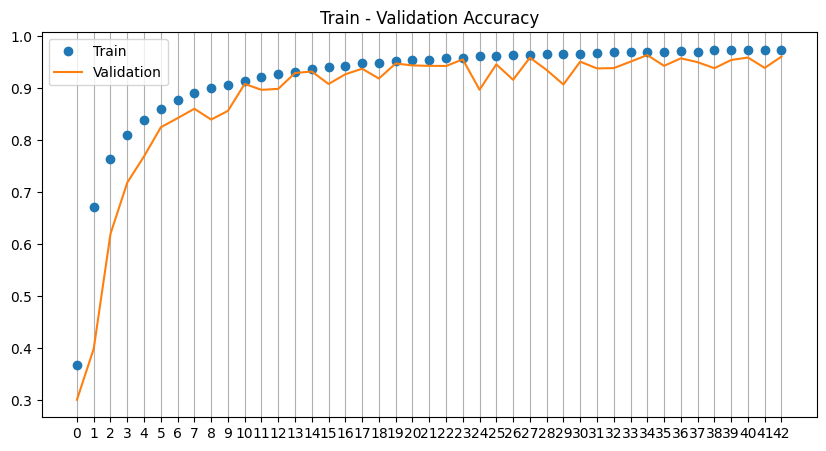

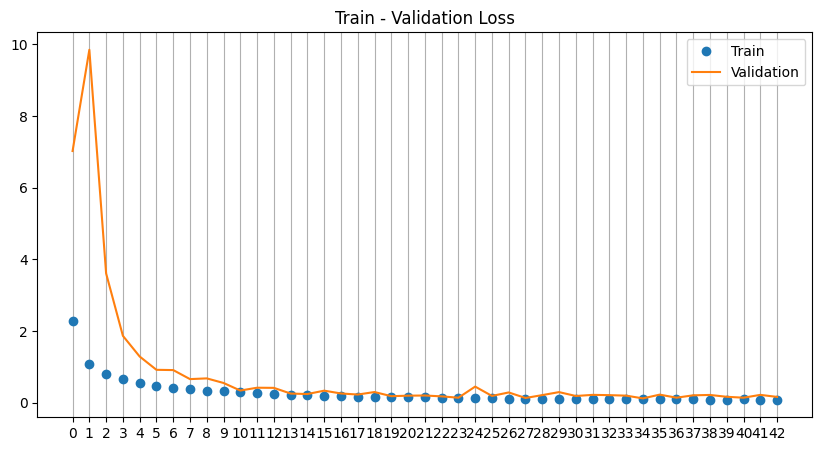

105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step


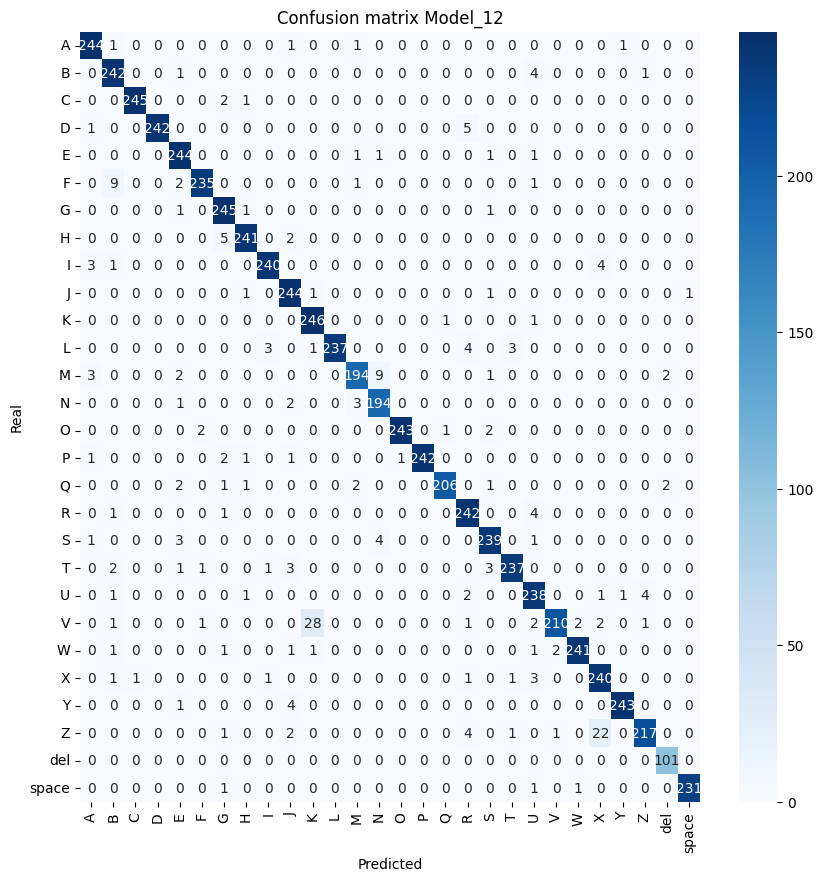

105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.9713 - loss: 0.0898
Test Accuracy: 0.9631
Max val Accuracy: 0.9638
Max train Accuracy: 0.9740


In [ ]:
evaluate_model('Model_12',model_12,history_12)

In [ ]:
save_model('model_12',model_12)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>